# Visual Analysis of Attacking an Idle Drone
In this data the drone is set to loiter in the air at an approximate height of
8m and set to hold position, altitude, and attitude. The GPS spoofing attack
written into the autopilot is enabled by controller with the target offset of
20m with a strength depending on the parameters. The collected data includes
a strength of 1m/s/s, 2m/s/s, and 4m/s/s, identified by the naming scheme
Live-C-Idle-Attack-`offset`-`strength`.log. The data files can be found
in the data subdirectory. Only interim data will be available on github to
preserve storage. For raw log files please contact me at
srimoungchanh.bailey@ku.edu.


For additional information about each sensor pair used in confirmation or a
more detailed explanation of the process refer to the
[exploration notebook](./0.1-bks-exploration.ipynb) using simulation data.

## Data Processing
The log `file` needs to be parsed out as the format is irregular, starting with
a csv of rows prefixed with FMT, indicating the log type and format. The FMT
rows will be parsed into headers and then the subsequent rows will be matched
on log name, i.e., "__SNS1__", "__SNS2__", "__SNS3__" and added to their
respective dataframes. The dataframes are then unioned on their timestamps to
create a single dataframe with all of the __SNS__ data. If an `output` path is
provided the newly created dataframe will be written to the path as a CSV.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import pandas as pd
import numpy as np
from confirmation.process import process_SNS
from os.path import exists

#Convert log file from Mission Planner to usable CSV
data_dir = "../data/"
file = "Live-C-Idle-Attack-2000-4.log" #Change file for different log files
output = data_dir + "interim/" + file[:-3] + "csv"

#Check if file exists already and if it does skip processing and read the file
if not exists(output):
    #Open log file and parse out the SNS data into pandas dataframes
    df = process_SNS(data_dir + "raw/" + file, output)
else:
    df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

## Gyroscope, Magnetometer, and Optical Flow

#### Magnetometer and Gyroscope Heading
__Important details to keep in mind:__

* Gyroscope only provides relative yaw so the
initial value is aligned to the initial magnetometer readings and integrated
from there.

* Magnetometer and Gyroscope are both only using their own readings with no
filter but there may be manufacturer specific offsets or scaling to get usable
data. Refer to ArduPilot 
[AP_AHRS](https://github.com/ArduPilot/ardupilot/tree/master/libraries/AP_AHRS)
and
[AP_Compass](https://github.com/ArduPilot/ardupilot/tree/master/libraries/AP_Compass)
libraries for more details.

For functions used in calculating heading from gyroscope and magnetometer refer
to the [process.py](../src/confirmation/process.py) file. Further details about
why certain sensors need to be processed a particular way to get confirmable
information is provided in the exploration notebook linked under the title.

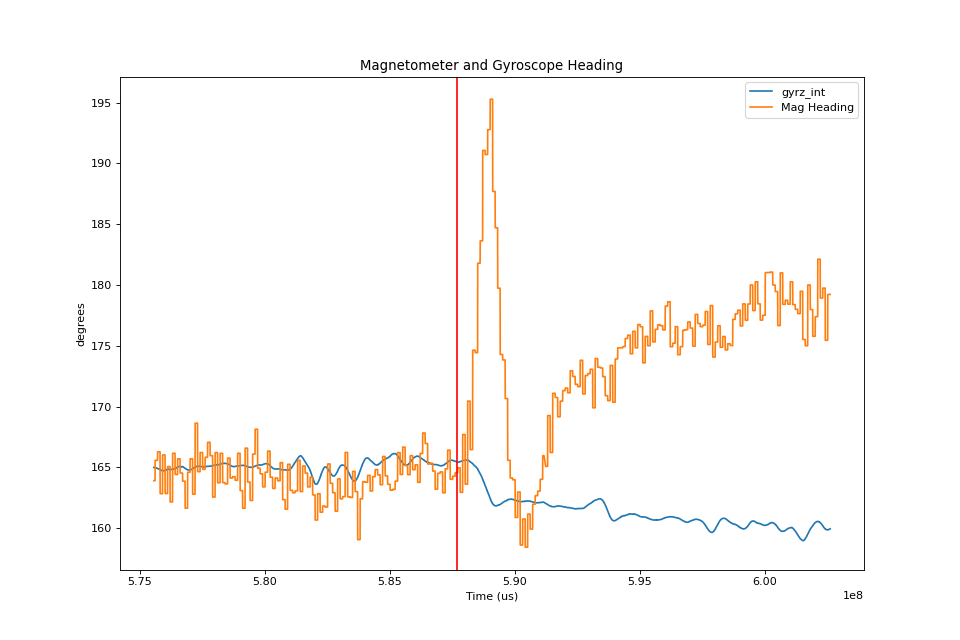

In [2]:
from confirmation.process import trap_integrate, mag_to_heading
from confirmation.visualize import simple_time_plot
from math import degrees

mag_heading = mag_to_heading(df.magz, df.magy, df.magx)
gyr_heading = trap_integrate(df.cUS / 1000000, df.gyrz).apply(degrees).cumsum() % 360
simple_time_plot(df.TimeUS[1:], [(gyr_heading-195) % 360, (mag_heading[1:]-180) % 360], ['us', 'degrees'], title="Magnetometer and Gyroscope Heading", atk=587680045)

Initially this result looks poor because the assumption is that since the GPS
is being spoofed the heading calculated from other sensors would be unaffected
and thereby still confirm correctly. An important consideration however is how
spoofing the GPS may lead to impacting not the physical characteristic derived
from a sensor but rather the phenomenon being read by the sensor itself. 
Spoofing the GPS causes the quadcopter to vary the RPM of the motors changing
the battery drain sporadically thereby altering the magnetic field around the
quadcopter; indirectly impacting the magnetometer derived heading. The graph
provided by UAV log viewer displayed below marks the spike in magnetometer
readings which comes immediately after GPS spoofing which starts at 587 seconds
.

![heading_mag_gyro](../reports/figures/Heading_Mag_Gyro_Attack.PNG)

#### Magnetometer and Gyroscope Pitch
__Important details to keep in mind:__

* Gyroscope only provides relative yaw so the
initial value is aligned to the initial magnetometer readings and integrated
from there.

* Magnetometer and Gyroscope are both only using their own readings with no
filter but there may be manufacturer specific offsets or scaling to get usable
data. Refer to ArduPilot 
[AP_AHRS](https://github.com/ArduPilot/ardupilot/tree/master/libraries/AP_AHRS)
and
[AP_Compass](https://github.com/ArduPilot/ardupilot/tree/master/libraries/AP_Compass)
libraries for more details.

For functions used in calculating pitch from gyroscope and magnetometer refer
to the [process.py](../src/confirmation/process.py) file. Further details about
why certain sensors need to be processed a particular way to get confirmable
information is provided in the exploration notebook linked under the title.

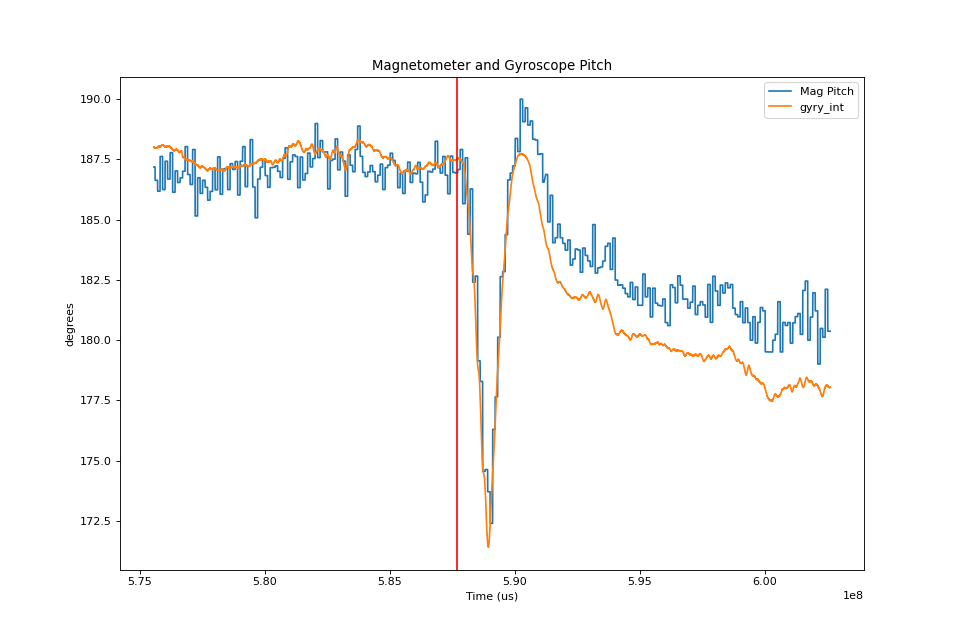

In [3]:
from confirmation.process import mag_to_pitch

#Gyroscope pitch, same as before with heading
gyr_pitch = trap_integrate(df.cUS / 1000000, df.gyry).apply(degrees).cumsum() % 360

#Magnetometer pitch
mag_pitch = mag_to_pitch(df.magz, df.magy, df.magx)
simple_time_plot(df.TimeUS[1:], [mag_pitch[1:], (gyr_pitch+188)%360], ["us","degrees"], title="Magnetometer and Gyroscope Pitch", atk=587680045)

The point in which the drone pitches is when the attack begins. In order to
move around, in response to the attack, the drone has to pitch which is
seen at the dip in the results at 5.87 seconds. We had mentioned before that
the attack caused changes in the magnetic field that were observable in the
heading calculated before but it would appear that the pitch was unaffected.
The lack of spiking in magnetometer data could either mean the readings in the
heading were a fluke and the attack is not observable in unrelated sensor
results or that the only axis of the magnetic field impacted by the quadcopters
response was related to the heading. The axis of the magnetic field being
impacted can be verified by looking at the plot of all three magnetic fields.
Displayed below is this plot:

![mag_field](../reports/figures/Mag_Field_During_GPS_Attack.png)

As can be seen in the above figure, only the x axis of the magnetic field was
impacted which clarifies why the heading was impacted but the pitch wasn't.
Heading calculations use the x and y axis of the magnetic field but pitch
calculations use the y and z axis.

### Optical Flow and Magnetometer Pitch
__Important details to keep in mind:__

* Optical flow measures the flow rate beneath the quadcopter, not the body rate.
An important case of measuring the flow rate is when the quadcopter is idle the
flow rate must be equal to the body rate.

* Optical flow measures the flow rate about an axis meaning the flow x value is
the flow about the x axis and flow y is flow about the y axis. The SNS logs due
away with this notation, renaming to flow forward and flow right or flow f and
flow r respectively. The names hopefully make it clearer to know which way the
flow is occuring.

* Magnetometer and optical flow are both only using their own readings with no
filter but there may be manufacturer specific offsets or scaling to get usable
data. Refer to ArduPilot 
[AP_OpticalFlow](https://github.com/ArduPilot/ardupilot/tree/master/libraries/AP_OpticalFlow)
and
[AP_Compass](https://github.com/ArduPilot/ardupilot/tree/master/libraries/AP_Compass)
libraries for more details.

Pitch was derived from the magnetometer before and will not be
recalculated below.

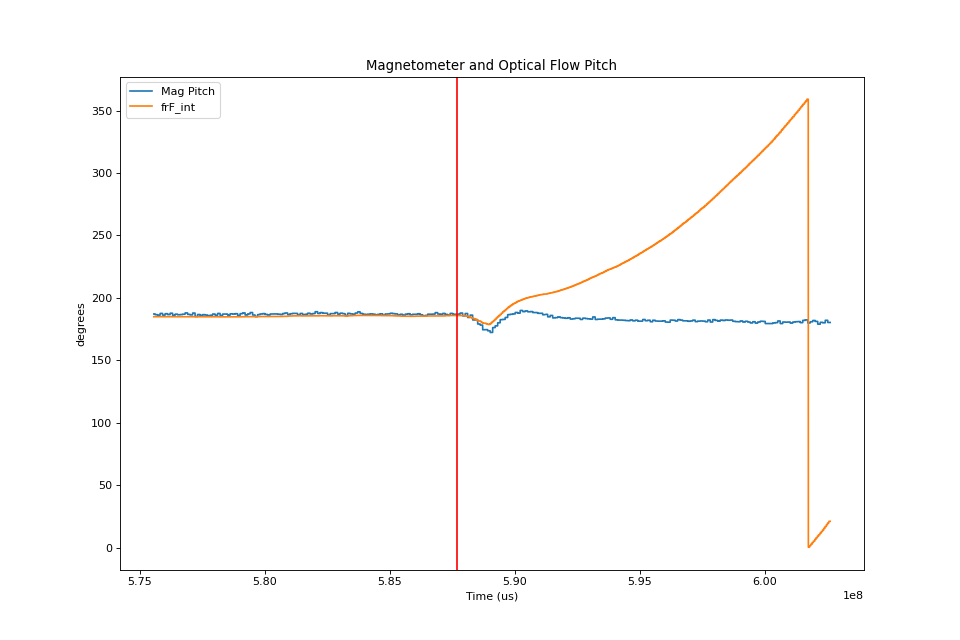

In [4]:
#Optical flow pitch, integrate flow rate in forward direction
of_pitch = trap_integrate(df.ofUS / 1000, df.frF).apply(degrees).cumsum() % 360

#Using the pitch derived from magnetometer from before
simple_time_plot(df.TimeUS[1:], [mag_pitch[1:], (of_pitch+185)%360], ["us","degrees"], title="Magnetometer and Optical Flow Pitch", atk=587680045)

The result isn't all too surprising. 

## GPS specific
Looking at specifically the GPS sensor there isn't an inherent value being
measured that can be directly compared to inertial sensors such as angular
rate. Instead, we will take a look at the different ways a GPS can be confirmed
even if each sensor pairing does not have an application to another sensor
pair. An example of this is using a barometer to confirm the GPS height
estimate while using the magnetometer to confirm the GPS heading (assuming
conditions are met).

__GPS__ provides positional data which is derived from information provided by
satellites and the signals used to transmit that information. A consequence of
using several satellites for position calculation is the absolute measurements
will have less accuracy depending on world model but the relative measurements
will still have decent accuracy. Below will be a list of confirmations we will
explore in this:

| **Measurement**             | **Rangefinder** | **Barometer** | **Magnetometer** | **Gyroscope** | **RF & OF** |   **Accelerometer &  (Gyroscope \|\| Magnetometer)**|
|-----------------------------|-----------------|---------------|------------------|---------------|-------------|-----------------------------------------------------|
| Above-Ground-Level Distance |      **x**      |     **x**     |                  |               |    **x**    |                        **x**                        |
| Heading                     |                 |               |       **x**      |     **x**     |             |                        **x**                        |
| Speed                       |                 |               |                  |               |    **x**    |                        **x**                        |

### Above-Ground-Level Distance

A commonly used measurement for navigation systems is the above-ground-level
(AGL) distance reading. A common requirement of flight is to maintain a certain
AGL distance for safety concerns, whether the drone needs a certain amount of
height to recover from system malfunction or simply avoiding being near people.
GPS systems calculate the AGL height by calculating their global position and
comparing the result to a world model, i.e., World Geodetic System 1984 (WGS84)
. 

A __rangefinder__ can get ranging measurements through different mediums. The
primary two types seen on quadcopters, and both present on the test platform,
are lidar and sonar rangefinders. Lidars generally have a higher range and
better accuracy but are suspectible to mediums altering readings such as dusty
environments or translucent surfaces. Sonars tend to be less suspectible to the
what they are measuring and can detect distance to clear objects but have a 
much shorter operating range. Typically, a lidar will be implemented for
general use but sonars see inclusion for landing systems. In the analysis that
follows the ranging sensor will be the lidar.

A __barometer__ measures the ambient pressure to determine altitude. Typically
the AGL height is determined as above-sea-level height when using a barometer
but for ease of use with the quadcopter platform the barometer calibrates to
the pressure at the launch point and calculates the relative altitude to the
launch point. Temperature measurements are used in the barometer to improve
accuracy with temperature compensation.

__RF & OF__ were included in the table but the primary reason is because of the
involvement of the RF. Refer to the previous section on the rangefinder for
details.

__Accelerometer__ can be used for AGL height in a similar fashion as the
barometer where an initial measurement is required and a height estimation is
made by integrating the accelerometer readings. A caveat of this approach is
knowing which way down is which is generally done by determining the gravity
vector but can become less accurate as other forces are acting. Given a drone
that is moving only on the z axis the AGL height estimation becomes easier and
less noisy.

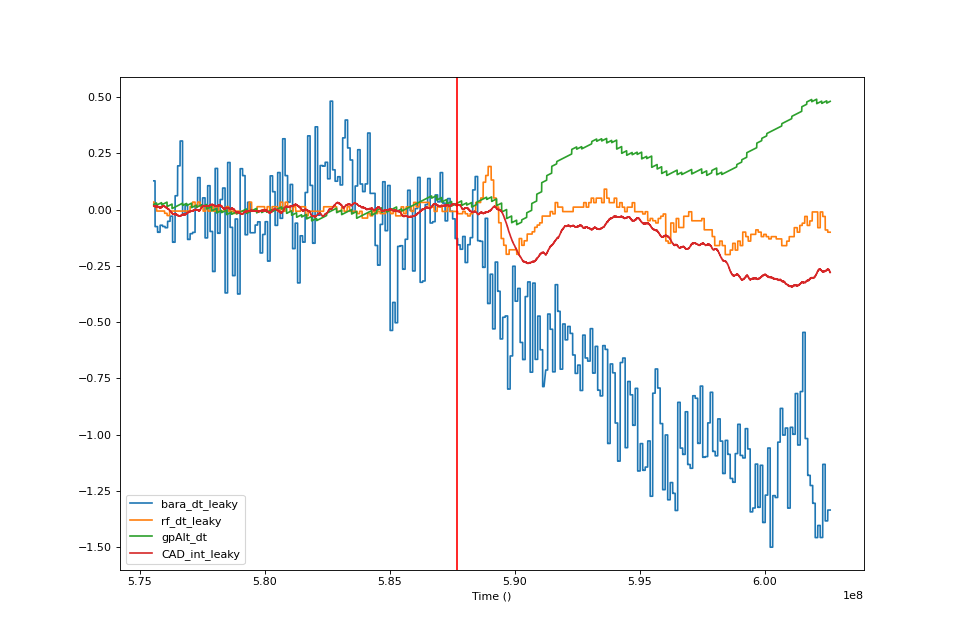

In [18]:
#Need both the low pass filter to reduce noise and change_in_signal to compare
#change rather than raw value
from confirmation.process import change_in_signal, leaky_integrator

acc_alt = leaky_integrator(trap_integrate(df.cUS/1000000, df["CAD"]), 1).cumsum()
bar_alt = leaky_integrator(change_in_signal(df.bara), 1).cumsum()
rf_alt = leaky_integrator(change_in_signal(df.rf/100), 1).cumsum()
gp_alt = change_in_signal(df.gpAlt/100).cumsum()

indices = [0, 9146]
simple_time_plot(df.TimeUS[1:],
                 [linear_bias(df.TimeUS[1:], bar_alt, indices),
                  linear_bias(df.TimeUS[1:], rf_alt, indices),
                  linear_bias(df.TimeUS[1:], gp_alt, indices),
                  linear_bias(df.TimeUS[1:], acc_alt, indices)],
                 atk=587680045)

### Velocity

Speed is a difficult measurement to use for confirmation, especially velocity,
as the added number of sensors increases the error margins of the results. For
velocity we are more reliant on the relative readings of the GPS to get the
advertised speed accuracy in the documentation, 0.05m/s, rather than looking
at absolute position data. An important consideration when doing confirmation
of velocity is the reference frame confirmation takes place in. When looking
primarily at the GPS the measurements for velocity will be in an Earth-Centered
Earth-Fixed (ECEF) frame with the velocity measurements being along the north,
east, and down axis. The reference frame is important because while the GPS is
in an ECEF frame, the other sensors such as OF, RF, accelerometer, gyroscope,
and magnetometer are in body frame with the orientation of the sensor being
compensated for. The solution to the reference frame issue is the magnetometer
or starting from a known position and using the gyroscope to rotate the
reference frame during flight. The process of tracking orientation and deriving
a rotation matrix usually results in a rotation matrix represented as Euler
angles or a quaternion.

__RF & OF__ provide only north and east velocity measurements provided a
rotation from body frame to ECEF frame is available. The method works by
calculating the flow rate of an image below the platform and compensating for
body tilt, usually with a gyroscope. Assuming body tilt is accounted for then
the flow rate being measured below the platform must be a result of lateral
movement. Combining the percieved flow rate with a range measurement the
velocity can be determined as described in the below figure:

![opticalflow](../reports/figures/OpticalFlow-1.png)

Where $\theta$ is the preceived flow rate, $d_{rf}$ is the AGL range, and
$d_{rf}*tan(-\theta)$ is the optical flow velocity. An important note about the
optical flow and rangefinder setup is the results tend to be noisier than other
sensors.